In [1]:
%matplotlib inline
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import polygon
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as K
from keras.applications.imagenet_utils import decode_predictions
import requests
from glob import glob
from thirdparty import Classifiers

import tensorflow as tf
from tensorflow.keras.layers import Input
import os
import time

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


# \[ 평가 이미지 - 뱀 사진들 \]
---

> 모델의 Input 값 범위를 알기 위해서는, Input 값 범위에 민감하게 변하는 케이스를 바탕으로 판단하는 것이 좋을 것입니다. 동물 중 뱀은 그 종류가 다양한데, 형상은 다들 비슷하지만, 띄고 있는 색에 따라 종이 달라지므로, 뱀 사진을 기반으로 평가 데이터셋을 구성하여 모델이 얼마나 정확하게 구분하는지를 파악하도록 하겠습니다.

## 1. 이미지넷 내 뱀 이미지 가져오기
---

In [2]:
# 이미지넷 내 뱀 이미지들을 위주로 집합
filepaths = [filepath 
 for filepath in glob("../test/backbone_test/*/*") 
 if ".png" in filepath ]

images = []
true_labels = []
for filepath in filepaths:
    image = cv2.imread(filepath)
    true_labels.append(filepath.split('/')[-2])
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

images = np.stack(images)

## 2. 이미지넷 내 뱀 이미지 시각화
----

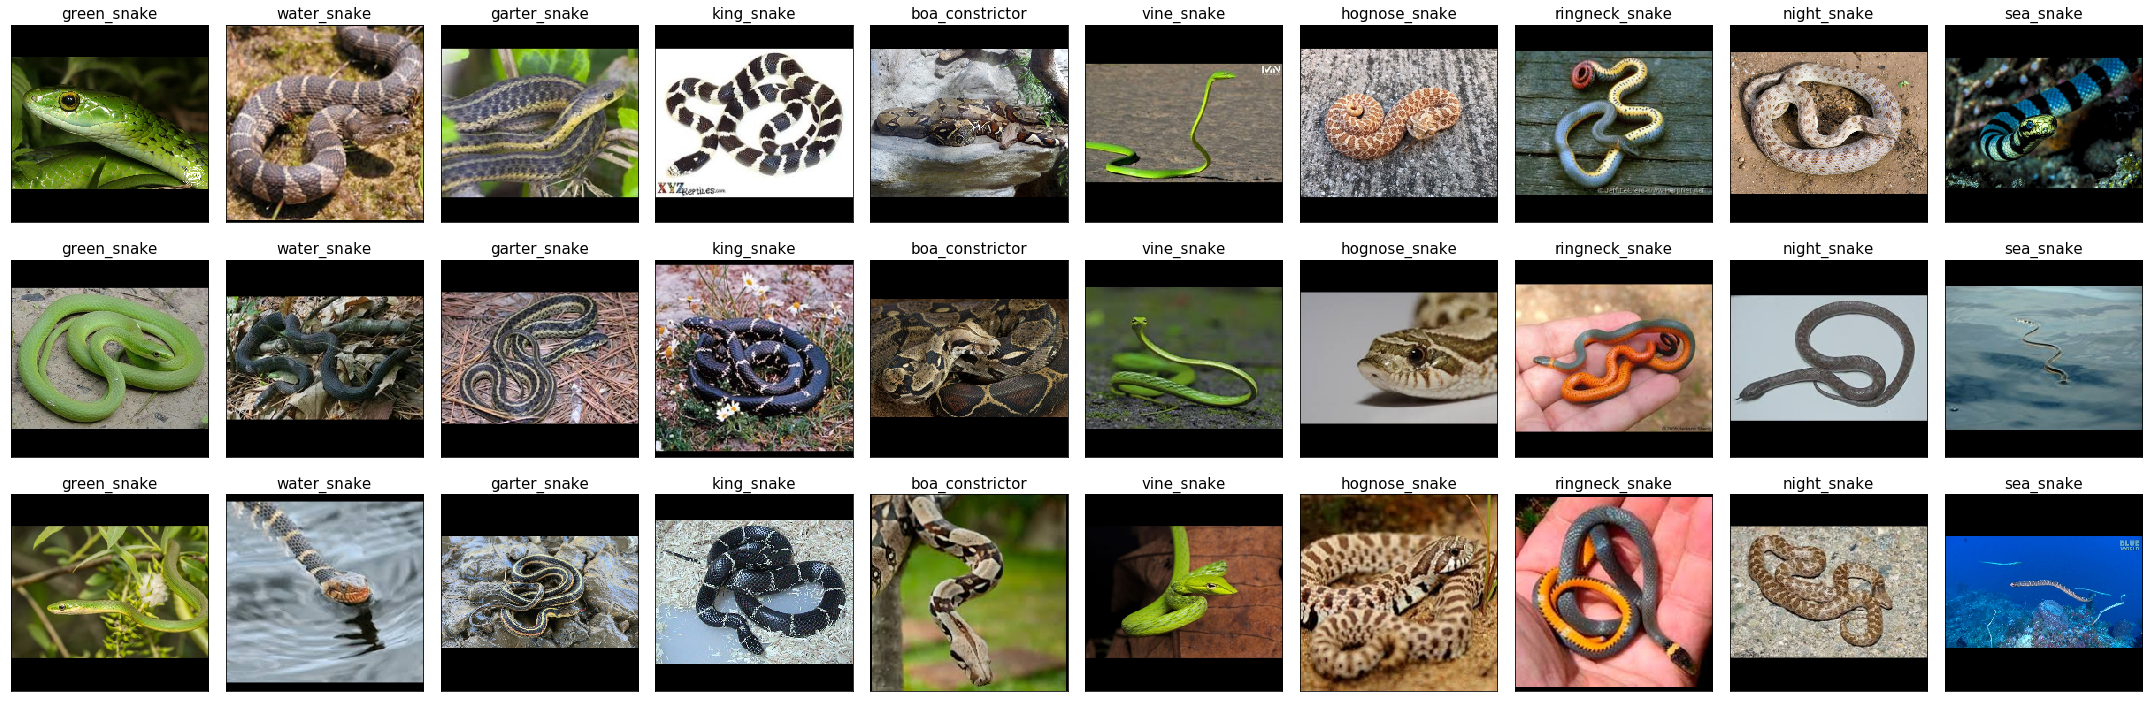

In [3]:
fig = plt.figure(figsize=(30,10))

nums = len(images)
n_rows = 3
n_cols = 10

for c in range(n_cols):
    for r in range(n_rows):        
        ax = fig.add_subplot(n_rows, n_cols, n_cols*r + c+1)
        ax.set_title(true_labels[n_rows*c + r],fontsize=15)
        ax.imshow(images[n_rows*c + r])
        ax.set_xticks([]); ax.set_yticks([]);
plt.tight_layout()
plt.show()        

# \[ 모델 별 최적의 Preprocess 식 산출하기 \]
---

> 모델의 Input 값 범위를 알기 위해서는, Input 값 범위에 민감하게 변하는 케이스를 바탕으로 판단하는 것이 좋을 것입니다. 동물 중 뱀은 그 종류가 다양한데, 형상은 다들 비슷하지만, 띄고 있는 색에 따라 종이 달라지므로, 뱀 사진을 기반으로 평가 데이터셋을 구성하여 모델이 얼마나 정확하게 구분하는지를 파악하도록 하겠습니다.

## 1. Preprocess 식 구성하기
---

Preprocess는 3가지 방식의 조합으로 이루어져 있습니다. 

* 채널의 순서 : RGB 순서 OR BGR 순서
* 중앙값을 빼줄지 유무
* 정규화를 적용할지 유무

In [ ]:
def preprocess(image, rgb=True, mean_shift=False, normalize=0):
    mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    std = np.array([ 0.225, 0.224, 0.229], dtype=np.float32)
    if not rgb:
        image = image[...,::-1]
        mean = mean[::-1]
        std = std[::-1]
    
    if mean_shift:
        image = image - mean

    if normalize == 1:
        image = image / 255.
    elif normalize == 2:
        if mean_shift:
            image = image / 127.5
        else:
            image = image / 127.5 -1.
    elif normalize == 3:
        image = image / 255.
        image = image / std
    else:
        image = image
    return image

def search_matched_preprocess_method(model, backbone):
    """
    Preprocess 조합에 따른 성능비교
    """    
    global images
    print("최적의 Preprocess 구성을 탐색")
    acc = 0
    s = time.time()
    for rgb in [True,False]:
        for mean_shift in [True, False]:
            for normalize in range(0,4):
                preprocessed = preprocess(images.copy(), 
                                          rgb, mean_shift, normalize)
                output = model.predict(preprocessed)
                results = decode_predictions(output,top=1)
                pred_labels = [result[0][1:] for result in results]
                tp = np.sum([p[1] for t, p in zip(true_labels, pred_labels) 
                             if t==p[0]])
                curr_acc = tp/len(true_labels)*100
                if curr_acc > acc:
                    acc = curr_acc
                    prep_arguments = (rgb, mean_shift, normalize)
                print(f"  * RGB : {rgb} | mean_shift : {mean_shift} | normalize : {normalize}  : {curr_acc:2.2f}%")

    c = time.time()-s
    print(f"완료 ---- 소요시간: {c:.3f}s")
    
    print("Backbone의 Stride Policy 탐색 (Ceil or Floor)")
    shape = backbone.predict(np.ones((1,243,243,3))).shape[1:]
    print(f"Input이 (243,243,3)일 때, backbone의 출력 크기 : {shape}\n")
    if shape[0] == 8:
        policy = 'ceil(올림)'
    else:
        policy = 'floor(버림)'
    
    print("요약 정리")
    tot_params = backbone.count_params()
    print(f"backbone의 전체 파라미터 수 : {tot_params:,}개")
    print(f"최적 Preprocess 조합: {prep_arguments} -> ACC : {acc:2.2f}%")     
    print(f"backbone의 Stride policy : {policy}")

## 2.  모델 별 평가하기
----

Backbone Network로 주로 이용되는 것들을 산출하였습니다.

### (1) VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

s = time.time()
print("모델 불러오기")
model = VGG16()
backbone = VGG16(include_top=False)
c = time.time() -s 
print(f"완료 ---- 소요시간 : {c:.3f}s")
search_matched_preprocess_method(model, backbone)

### (2) VGG19

In [ ]:
from tensorflow.keras.applications import VGG19

s = time.time()
print("모델 불러오기")
model = VGG19()
backbone = VGG19(include_top=False)
c = time.time() -s 
print(f"완료 ---- 소요시간 : {c:.3f}s")

print("최적의 Preprocess 구성 Search")
search_matched_preprocess_method(model, backbone)

### (3) MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet

s = time.time()
print("모델 불러오기")
model = MobileNet(alpha=1.0)
backbone = MobileNet(include_top=False)
c = time.time() -s 
print(f"완료 ---- 소요시간 : {c:.3f}s")
search_matched_preprocess_method(model, backbone)

### (4) ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

s = time.time()
print("모델 불러오기")
model = ResNet50()
backbone = ResNet50(include_top=False)
c = time.time() -s 
print(f"완료 ---- 소요시간 : {c:.3f}s")
search_matched_preprocess_method(model, backbone)

### (5) ResNet101

In [ ]:
from keras_applications.resnet_v2 import ResNet101V2

s = time.time()
print("모델 불러오기")
model = ResNet101V2(
    backend=tf.keras.backend,
    layers=tf.keras.layers,
    models=tf.keras.models,
    utils=tf.keras.utils)
backbone = ResNet101V2(
    include_top=False,
    backend=tf.keras.backend,
    layers=tf.keras.layers,
    models=tf.keras.models,
    utils=tf.keras.utils)
c = time.time() -s 
print(f"완료 ---- 소요시간 : {c:.3f}s")
search_matched_preprocess_method(model, backbone)

### (6) ResNext50

In [ ]:
from models.backbone.ResNext import ResNeXt50

s = time.time()
print("모델 불러오기")
model = ResNeXt50()
backbone = ResNeXt50(include_top=False)
c = time.time() -s 
print(f"완료 ---- 소요시간 : {c:.3f}s")
search_matched_preprocess_method(model, backbone)

### (7) SeResNet50

In [ ]:
from thirdparty import Classifiers

s = time.time()
print("모델 불러오기")
seresnet50, _ = Classifiers.get('seresnet50')

inputs = Input(shape=(None,None,3))
model = seresnet50(input_tensor=inputs,
                   original_input=inputs,
                   include_top=True,
                   weights='imagenet')
backbone = seresnet50(input_tensor=inputs,
                     original_input=inputs,
                     include_top=False,
                     weights='imagenet')

c = time.time() -s 
print(f"완료 ---- 소요시간 : {c:.3f}s")
search_matched_preprocess_method(model, backbone)

### (8) SeResNext50

In [ ]:
from thirdparty import Classifiers

s = time.time()
print("모델 불러오기")
seresnext50,_ = Classifiers.get('seresnext50')

inputs = Input(shape=(None,None,3))
model = seresnext50(input_tensor=inputs,
                    original_input=inputs,
                    include_top=True,
                    weights='imagenet')
backbone = seresnext50(input_tensor=inputs,
                    original_input=inputs,
                    include_top=False,
                    weights='imagenet')

c = time.time() -s 
print(f"완료 ---- 소요시간 : {c:.3f}s")
search_matched_preprocess_method(model, backbone)